In [5]:
import numpy as np
from scipy.stats import multivariate_normal
import pandas as pd
import matplotlib.pyplot as plt

In [6]:

from sklearn.cluster import KMeans
from scipy.linalg import cholesky, LinAlgError
from sklearn.mixture import GaussianMixture

In [7]:
def compute_initial_parameters(data, initial_clusters):
    """
    Compute the initial parameters of a Gaussian Mixture Model.

    Args:
    data (np.ndarray): The dataset from which the clusters were derived.
    initial_clusters (np.ndarray): The initial clusters used to initialize the Gaussian Mixture Model.

    Returns:
    mean (list): A list of means for each cluster.
    covariance (list): A list of covariance matrices for each cluster.
    class_probabilities (np.ndarray): A 1D numpy array where each entry stores the initial mixing coefficient for each cluster.

    """

    N = data.shape[0]
    K = initial_clusters.shape[0]

    min_dist = np.array([np.inf] * N)
    assignment = np.array([-2] * N)

    for i in range(K):
        distance = np.sum(np.square(data - initial_clusters[i, :]), axis=1)
        assigned_new = np.where(distance < min_dist)
        min_dist[assigned_new] = distance[assigned_new]
        assignment[assigned_new] = i

    clusters = []
    for i in range(K):
        clusters.append(data[np.where(assignment == i)])

    # Initial mean, covariance, and class probabilities
    covariance = []
    for cluster in clusters:
        if cluster.shape[0] > 1:  # More than one data point in the cluster
            cov = np.cov(cluster, rowvar=False)
        else:  # Single data point in a cluster or no points
            cov = np.eye(data.shape[1]) * 1e-6  # Small identity matrix
        covariance.append(cov)
    # variances = [np.var(clusters[i], axis=0, ddof=1) for i in range(K)]
    # covariance = [np.diag(variances[i]) for i in range(K)]
    mean = initial_clusters
    class_probabilities = np.array([len(clusters[i])/N for i in range(K)])

    return mean, covariance, class_probabilities


In [8]:
import numpy as np

def check_psd_covar(covariance: list) -> list:
    """
    Ensure all covariance matrices in the list are positive semi-definite.
    If a matrix is not positive semi-definite, it is adjusted by adding a small value to its diagonal.

    Args:
        covariance (list): A list of np.ndarray, where each ndarray is a covariance matrix.

    Returns:
        list: A list of adjusted covariance matrices, all of which are positive semi-definite.
    """
    for i, cov in enumerate(covariance):
        # Check if the covariance matrix is positive semi-definite
        # if not np.all(np.linalg.eigvals(cov) >= 0):  
        #     # Find the minimum eigenvalue and adjust it if it's negative or zero
        #     min_eigenvalue = np.min(np.linalg.eigvals(cov))
        #     adjustment = 0 if min_eigenvalue > 0 else -min_eigenvalue + 1e-6
        #     adjusted_cov = cov + adjustment * np.eye(cov.shape[0])
        #     covariance[i] = adjusted_cov
        covariance[i] += np.eye(cov.shape[0]) * 1e-6  # Small identity matrix
    return covariance


In [9]:
from scipy.stats import multivariate_normal
# z latent variable - each row i stores the distribution of the training instance x_i, each entry stores p(x_i | z_k) for k = 1:K)
# Dimension: N x K
def compute_likelihood_matrix(data, mean, covariance, K: int):
    """
    Compute the likelihood matrix for a Gaussian Mixture Model.

    Args:
    data (np.ndarray): The dataset from which the clusters were derived.
    clusters (list): A list of clusters, where each cluster contains the indices of data points in that cluster.
    mean (list): A list of means for each cluster.
    covariance (list): A list of covariance matrices for each cluster.
    K: number of clusters

    Returns:
    likelihood_matrix (np.ndarray): A 2D numpy array where each row i stores the distribution of the training instance x_i, each entry stores p(x_i | z_k) for k = 1:K.
    """

    likelihood_matrix = np.array([[multivariate_normal.pdf(x, mean[i], covariance[i], allow_singular=False) for i in range(K)] for x in data])

    return likelihood_matrix

In [10]:
def compute_log_likelihood(likelihood_matrix: np.ndarray, class_probabilities: np.ndarray) -> float:
    """
    Compute the log likelihood of the data given the latent variables.

    Args:
    likelihood_matrix (np.ndarray): A 2D numpy array where each row represents the likelihood of a data point belonging to a particular cluster.
    class_probabilities (np.ndarray): A 1D numpy array where each entry stores the mixing coefficient for each cluster.
   
    Returns:
    float: The log likelihood of the data given the latent variables.
    """
    return np.sum(np.log(likelihood_matrix @ class_probabilities))

In [11]:
def E_step(likelihood_matrix: np.ndarray, class_probabilities: np.ndarray) -> np.ndarray:
    """
    Estimate the responsibility matrix that expresses how much a Gaussian accounts for each instance.

    Args:
        likelihood_matrix (np.ndarray): likelihood matrix N x K, where N is the number of instances and K is the number of Gaussians.
        class_probabilities (np.ndarray): mixing coefficient K x 1, where K is the number of Gaussians.

    Returns:
        responsibility_matrix (np.ndarray): responsibility matrix N x K, where N is the number of instances and K is the number of Gaussians.

    The responsibility matrix is a matrix that expresses the degree to which each Gaussian is responsible for generating each instance. It is computed as the product of the likelihood matrix and the class probabilities, divided by the normalization factor.
    """
    weighted_likelihood = likelihood_matrix * class_probabilities.reshape(1, -1)  # element-wise multiplication
    normalization = np.sum(weighted_likelihood, axis=1, keepdims=True)  # sum along the instances axis
    responsibility_matrix = likelihood_matrix * class_probabilities.reshape(1, -1) / normalization  # element-wise division
    return responsibility_matrix


In [12]:
def M_step(data: np.ndarray, responsibility_matrix: np.ndarray):
    """
    Compute the new parameters of the Gaussian Mixture Model based on the responsibility matrix.

    Args:
    data (np.ndarray): The dataset from which the clusters were derived.
    responsibility_matrix (np.ndarray): A 2D numpy array where each row i stores the distribution of the training instance x_i, each entry stores p(x_i | z_k) for k = 1:K.

    Returns:
    mean_new (list): A list of new means for each cluster.
    covariance_new (list): A list of new covariance matrices for each cluster.
    class_probabilities_new (np.ndarray): A 1D numpy array where each entry stores the new mixing coefficient for each cluster.

    """
    N_k = np.sum(responsibility_matrix, axis=0)
    N = np.sum(N_k)

    K = responsibility_matrix.shape[1]
    mean_new, covariance_new = [], []

    for i in range(K):
        mean_new.append(responsibility_matrix[:, i] @ data / N_k[i])

    for i in range(K):
        cov = (((data - mean_new[i]).T * responsibility_matrix[:, i]) @ (data - mean_new[i])) / N_k[i]
        covariance_new.append(cov)

    class_probabilities_new = N_k / N

    return mean_new, covariance_new, class_probabilities_new

In [13]:

def run_GMM_EM(data: np.ndarray, K: int, convergence_threshold=1e-6, random_seed=12345, take_snapshots=True):
    """
    Runs the Expectation-Maximization (EM) algorithm for a Gaussian Mixture Model (GMM).

    Args:
        data (np.ndarray): The dataset from which the clusters were derived.
        K (int): The number of clusters in the Gaussian Mixture Model.
        convergence_threshold (float): The threshold for convergence. 
        random_seed (int): The seed for the random number generator used to initialize the clusters.

    Returns:
        cur_log_likelihood (float): The log likelihood of the data given the latent variables at the end of the algorithm.
        cur_mean (np.ndarray): A 2D numpy array where each row i stores the mean of the i-th cluster.
        cur_covar (np.ndarray): A 2D numpy array where each row i stores the covariance matrix of the i-th cluster.
        cur_class_probabilities (np.ndarray): A 1D numpy array where each entry stores the mixing coefficient for the i-th cluster.

    The function first initializes the means, covariance matrices, and class probabilities of the Gaussian Mixture Model. 
    Then, it iteratively performs the E-step and the M-step until the difference in log likelihood between two consecutive iterations is less than the convergence threshold.
    """

    kmeans = KMeans(n_clusters=K, random_state=random_seed, init='k-means++')

    kmeans.fit(data)

    initial_means = kmeans.cluster_centers_

    mean, covariance, class_probabilities = compute_initial_parameters(data, initial_means)

    covariance = check_psd_covar(covariance)

    dif_log_likelihood = np.inf

    cur_mean, cur_covar, cur_class_probabilities = mean, covariance, class_probabilities

    cur_log_likelihood = compute_log_likelihood(compute_likelihood_matrix(data, mean, covariance, K), class_probabilities)

    snapshots = []

    iterations = 0

    while (dif_log_likelihood > convergence_threshold):

        # Old log likelihood
        old_log_likelihood = cur_log_likelihood

        # E-step
        estimated_responsibility_matrix = E_step(compute_likelihood_matrix(data, cur_mean, cur_covar, K), cur_class_probabilities)

        # M-step
        cur_mean, cur_covar, cur_class_probabilities = M_step(data, estimated_responsibility_matrix)

        cur_covar = check_psd_covar(cur_covar)

        # Compute difference in log likelihood
        new_log_likelihood = compute_log_likelihood(compute_likelihood_matrix(data, cur_mean, cur_covar, K), cur_class_probabilities)

        cur_log_likelihood = new_log_likelihood

        dif_log_likelihood = cur_log_likelihood - old_log_likelihood

        snapshots.append(cur_log_likelihood)
    

    plt.plot(np.arange(1, len(snapshots)+1), snapshots)

    
    return cur_log_likelihood, cur_mean, cur_covar, cur_class_probabilities, snapshots


In [64]:
# Read the data from txt file into a numpy array (rows x columns)
def parse_data_from_file_txt(filename: str):
    """
    Get data from a text file and parse them into numpy array

    Args:
        filename: name of the file (within the same folder as this notebook)
    """
    data = np.genfromtxt(filename, dtype=np.float64)
    return data

def parse_data_from_file_csv(filename: str):
    """
    Get data from a text file and parse them into numpy array

    Args:
        filename: name of the file (within the same folder as this notebook)
    """
    df = pd.read_csv(filename)
    return df

# raw_iyer_data = parse_data_from_file_txt('iyer_gene_data.txt')
 
# # Exclude the gene_id and labels from the data (first 2 columns) + baseline column (0 variance)
# iyer_data = raw_iyer_data[:, 3:]
# iyer_labels = raw_iyer_data[:, 1] # labels
# standardized_data = (iyer_data - iyer_data.mean(axis=0)) / iyer_data.std(axis=0)
# print(standardized_data)

raw_breast_cancer_data_df = parse_data_from_file_csv('breast_cancer_data.csv')

bc_data = raw_breast_cancer_data_df.iloc[:, 2:-2].apply(pd.to_numeric, errors='coerce')
bc_labels = raw_breast_cancer_data_df.iloc[:, 1] # labels
standardized_data = (bc_data - bc_data.mean(axis=0)) / bc_data.std(axis=0)
standardized_data = standardized_data.to_numpy()
vectorized_func = np.vectorize(lambda x: 1 if x == 'M' else 0)
labels_data = vectorized_func(bc_labels)



In [15]:
import numpy as np

def create_bags_of_labels(standardized_data, labels_data, threshold_ratio=1):
    """
    Create bags of labels for data that meets a specified count threshold.

    :param standardized_data: A NumPy array of standardized feature data.
    :param labels_data: A NumPy array of corresponding labels.
    :param threshold_ratio: A multiplier for the threshold based on the number of features. Defaults to 1.
    :return: A tuple containing a list of bags of labels and a list of corresponding labels.
    """
    bags_of_labels = []
    labels = []

    # Feature count threshold
    threshold = threshold_ratio * standardized_data.shape[1]

    # Iterate over each unique label to create bags of labels with the specified count
    for label in np.unique(labels_data):
        # Get the standardized data for the current label
        class_data = standardized_data[np.where(labels_data == label)]
        
        # Add to bags if it meets the count criterion
        if len(class_data) > threshold:
            bags_of_labels.append(class_data)
            labels.append(int(label))

    return bags_of_labels, labels

In [16]:

def initialize_parameters_gmm(bags_of_labels, num_clusters=3):
    pi_ij = []
    mean_ij = []
    covariance_ij = [] 
    prior_omega = []
    num_clusters = num_clusters
    # for i, bag in enumerate(bags_of_labels):
    #     kmeans = KMeans(n_clusters=num_clusters, init='k-means++', random_state=12345).fit(bag)
    #     initial_means = kmeans.cluster_centers_
    #     _, covariances, _ = compute_initial_parameters(bag, initial_means)
    #     covariances = check_psd_covar(covariances)
    #     log_likelihood, mean, covar, class_prob, _ = run_GMM_EM(bag, K=num_clusters, take_snapshots=False)
    #     c_ik.append(class_prob)
    #     mean_ik.append(mean)
    #     covariance_ik.append(covar)
    #     prior_omega.append(len(bag)/N)

    N = sum([len(bag) for bag in bags_of_labels])
    for i, bag in enumerate(bags_of_labels):
        # Initialize and fit the GMM
        gmm = GaussianMixture(n_components=num_clusters, random_state=12345, covariance_type='diag').fit(bag)
        
        # Store the class probabilities (responsibilities) for each data point
        mixing_coeffs = gmm.weights_
        pi_ij.append(mixing_coeffs)
        
        # Store the means and covariances learned by the GMM
        mean_ij.append(gmm.means_)
        covariance_ij.append(gmm.covariances_)
        
        # Calculate the prior probability for the class based on the bag size
        prior_omega.append(len(bag) / N)

    return np.array(pi_ij), np.array(mean_ij), np.array(covariance_ij), np.array(prior_omega)

In [54]:

def initialize_parameters_kmeans(bags_of_labels, num_clusters=3):
    pi_ij = []
    mean_ij = []
    covariance_ij = [] 
    prior_omega = []
    num_clusters = num_clusters
    
    N = np.sum([len(bag) for bag in bags_of_labels])

    for i, bag in enumerate(bags_of_labels):
    
        kmeans = KMeans(n_clusters=num_clusters, random_state=1, init='random')

        kmeans.fit(bag)

        initial_means = kmeans.cluster_centers_

        # mean, covariance, class_probabilities = compute_initial_parameters(bag, initial_means)

        pi_ij.append([1 / num_clusters] * num_clusters)
        mean_ij.append(initial_means)
        covariances = []
        for j in range(num_clusters):
            cluster_points = bag[kmeans.labels_ == j]
            # Calculate variances for the diagonal covariance matrix
            # If the cluster is empty, use a small variance instead
            if len(cluster_points) > 0:
                variances = np.var(cluster_points, axis=0)
            else:
                variances = np.ones(bag.shape[1]) * 1e-6  # small variance for each feature
            cov_matrix = np.diag(variances)
            covariances.append(cov_matrix)
        covariance_ij.append(check_psd_covar(covariances))
        prior_omega.append(len(bag) / N)
        
    return np.array(pi_ij), np.array(mean_ij), np.array(covariance_ij), np.array(prior_omega)

In [18]:
# def marginal_x_ij(x: np.ndarray, bags_of_labels, c_ik: list, mean_ik: list, covariance_ik: list, prior_omega: list, K: int):
   
#    p_ik_x_ij = np.array([[multivariate_normal.pdf(x, mean_ik[i][k], covariance_ik[i][k]) for k in range(K)] for i in range(len(bags_of_labels))])
#    p_x_ij_given_omega_i = np.sum(p_ik_x_ij * np.array(c_ik), axis=1)
#    p_x_ij = p_x_ij_given_omega_i @ prior_omega
    
#    return p_x_ij + 1e-10

# # valid_count = 0
# # for i, bag in  enumerate(bags_of_labels):
# #    for j, x_ij in enumerate(bag):
# #       if marginal_x_ij(x_ij, bags_of_labels, c_ik, mean_ik, covariance_ik, prior_omega, K=num_clusters) < 1:
# #          valid_count += 1
# # print(valid_count/N)

In [19]:
def E_step_supervised(bags_of_labels, pi_ij: list, mean_ij: list, covariance_ij: list, prior_omega: list, J: int, beta=0.5):
    # Bags of class-specific responsibilities
    gamma_ikj_bags = [] 

    for i, bag in enumerate(bags_of_labels):
        p_x_given_z_c = np.array([[multivariate_normal.pdf(x, mean_ij[i][j], covariance_ij[i][j]) for j in range(J)] for x in bag])
        p_z_given_x_c = pi_ij[i] * p_x_given_z_c 
        gamma_ikj = p_z_given_x_c / np.sum(p_z_given_x_c, axis=1)[:, np.newaxis]
        gamma_ikj_bags.append(gamma_ikj)

    return gamma_ikj_bags


In [20]:
def M_step_supervised(bags_of_labels, gamma_ikj_bags, K):
    new_pi_ij = []
    new_mean_ij = []
    new_covariance_ij = []

    for i, bag_of_class in enumerate(bags_of_labels):
        N_ij = np.sum(gamma_ikj_bags[i], axis=0)

        new_pi_ij_class = N_ij / np.sum(N_ij)
        new_mean_ij_class = np.dot(gamma_ikj_bags[i].T, bag_of_class) / N_ij[:, np.newaxis]

        new_covariance_ij_class = []
        for j in range(K):
            deviations = bag_of_class - new_mean_ij_class[j]
            weighted_deviations = gamma_ikj_bags[i][:, j][:, np.newaxis] * deviations
            cov_ij = np.dot(weighted_deviations.T, deviations) / N_ij[j]
            new_covariance_ij_class.append(cov_ij)

        new_pi_ij.append(new_pi_ij_class)
        new_mean_ij.append(np.array(new_mean_ij_class))
        new_covariance_ij.append(np.array(new_covariance_ij_class))

    return np.array(new_pi_ij), np.array(new_mean_ij), np.array(new_covariance_ij)

In [21]:

import matplotlib.pyplot as plt
def supervised_GMM(data, labels_data, num_clusters=3, convergence_threshold=1e-6, max_iterations=100, plot=False):

    bags_of_labels, _ = create_bags_of_labels(data, labels_data)

    pi_ij, mean_ij, covariance_ij, prior_omega = initialize_parameters_kmeans(bags_of_labels, num_clusters)
    print(np.array(pi_ij).shape)
    print(pi_ij)
    print(np.array(mean_ij).shape)
    print(np.array(covariance_ij).shape)
    prev_log_likelihood = -np.inf  # Initialize previous log likelihood to negative infinity for comparison

    log_likelihood_track = []
    # Run the EM algorithm until convergence
    for iteration in range(1, max_iterations+1):  # You can also add a maximum number of iterations as a safeguard
        
        # E-step
        gamma_ikj_bags = E_step_supervised(bags_of_labels, pi_ij, mean_ij, covariance_ij, prior_omega, num_clusters)
        
        # print(gamma_ikj_bags[0])

        # M-step
        new_pi_ij, new_mean_ij, new_covariance_ij = M_step_supervised(bags_of_labels, gamma_ikj_bags, num_clusters)

        # print(new_pi_ij)

        new_covariance_ij = [check_psd_covar(list(cov_i)) for cov_i in new_covariance_ij]
        
        # Compute the log likelihood of the current model
        current_log_likelihood = compute_conditional_log_likelihood(bags_of_labels, new_pi_ij, new_mean_ij, new_covariance_ij, prior_omega, num_clusters)
        
        # Check for convergence
        if np.abs(current_log_likelihood - prev_log_likelihood) < convergence_threshold:
            print(iteration)
            break
        # Update the parameters for the next iteration
        pi_ij, mean_ij, covariance_ij = new_pi_ij, new_mean_ij, new_covariance_ij
        prev_log_likelihood = current_log_likelihood
        log_likelihood_track.append(prev_log_likelihood)

    if plot is True:
        plt.plot(np.arange(1, len(log_likelihood_track)+1), log_likelihood_track)
    
    return pi_ij, mean_ij, covariance_ij, log_likelihood_track

In [22]:
def compute_conditional_log_likelihood(bags_of_labels, pi_ij, mean_ij, covariance_ij, prior_omega, num_clusters):
    # This function should compute the log-likelihood of the current model given the data
    log_likelihood = 0

    for i, bag in enumerate(bags_of_labels):
        p_x_given_z_c = np.array([[multivariate_normal.pdf(x, mean_ij[i][j], covariance_ij[i][j]) for j in range(num_clusters)] for x in bag])
        log_likelihood += np.sum(np.log(p_x_given_z_c @ pi_ij[i] + 1e-8))

    return log_likelihood

In [23]:
def calculate_posterior_probabilities(x, pi_ij, mean_ij, covariance_ij, prior_omega, num_clusters):
    posterior_probs = []
    for i in range(len(mean_ij)):
        # Compute the likelihood of x for each component j in class i
        likelihoods = np.array([multivariate_normal(mean=mean_ij[i][j], cov=covariance_ij[i][j]).pdf(x) for j in range(num_clusters)])
        # Compute the total likelihood for class i by summing the component likelihoods weighted by their mixing coefficients
        total_likelihood = np.dot(likelihoods, pi_ij[i])
        # Apply Bayes' theorem to get the posterior probability for class i
        posterior_prob = total_likelihood * prior_omega[i]
        posterior_probs.append(posterior_prob)
    # Normalize the posterior probabilities so they sum to 1
    posterior_probs = np.array(posterior_probs) / (sum(posterior_probs) + 1e-8)
    return posterior_probs

In [24]:
def predict_single(x, pi_ij, mean_ij, covariance_ij, prior_omega, num_clusters):
    posterior_probs = calculate_posterior_probabilities(x, pi_ij, mean_ij, covariance_ij, prior_omega, num_clusters)
    prediction = np.argmax(posterior_probs)
    return prediction

In [25]:
def calculate_accuracy(predictions, ground_truth):
    correct_count = 0

    # Ensure that the length of predictions and ground_truth are the same
    if len(predictions) != len(ground_truth):
        raise ValueError("The length of predictions and ground truth labels must be the same.")

    # Count the number of correct predictions
    for pred, truth in zip(predictions, ground_truth):
        if pred == truth:
            correct_count += 1

    # Calculate the accuracy
    accuracy = correct_count / len(predictions)
    return accuracy


In [73]:
from sklearn.model_selection import train_test_split

raw_iyer_data = parse_data_from_file_txt("iyer.txt")
iyer_data = raw_iyer_data[:, 3:]
iyer_labels = raw_iyer_data[:, 1] # labels
standardized_iyer_data = (iyer_data - iyer_data.mean(axis=0)) / iyer_data.std(axis=0)
labels_data = iyer_labels

# Assuming X is your feature matrix and y is the target vector
X_train, X_test, y_train, y_test = train_test_split(standardized_iyer_data, labels_data, test_size=0.2, random_state=12345)

c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans 

(9, 1)
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
(9, 1, 11)
(9, 1, 11, 11)
2
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


IndexError: list index out of range

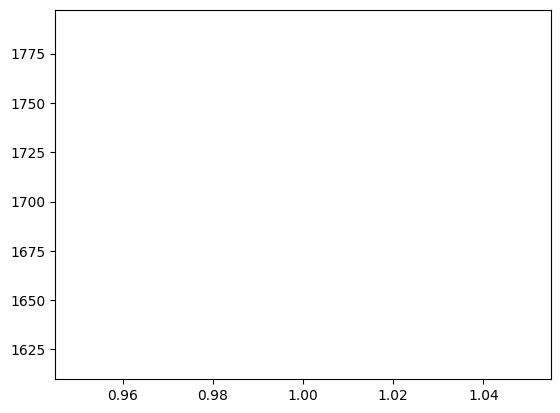

In [74]:
import matplotlib.pyplot as plt

max_num_clusters = 10
accuracy_arr = []
N = len(standardized_iyer_data)

# Assuming create_bags_of_labels and supervised_GMM functions are defined elsewhere
bags_of_labels = create_bags_of_labels(X_train, y_train)
prior_omega = [len(bag)/N for bag in bags_of_labels]


for num_cluster in range(1, max_num_clusters+1):
    c_ij, mean_ij, covariance_ij, log_likelihood_track = supervised_GMM(X_train, y_train, num_clusters=num_cluster, plot=True)
    print(c_ij)
    predictions = [predict_single(x, c_ij, mean_ij, covariance_ij, prior_omega, num_cluster) for x in X_train]
    accuracy_arr.append(calculate_accuracy(predictions, y_train))

# Now, let's plot the accuracies with proper title and annotations
plt.figure(figsize=(8, 6))  # Set the figure size for better readability
plt.plot(np.arange(1, max_num_clusters+1), accuracy_arr, marker='o')  # Adding a marker for each data point
plt.title('Model Accuracy vs Number of Subclasses')  # Title for the plot
plt.xlabel('Number of Subclasses (Clusters)')  # X-axis label
plt.ylabel('Model Accuracy')  # Y-axis label
plt.xticks(np.arange(1, max_num_clusters+1))  # Ensuring there's a tick for each number of clusters
plt.grid(True)  # Adding a grid for better readability

# Optionally, you can annotate each point with its accuracy
for i, txt in enumerate(accuracy_arr):
    plt.annotate(f"{txt:.4f}", (i + 1, txt), textcoords="offset points", xytext=(0,10), ha='center')

plt.show()  # Display the plot


In [52]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.cluster import KMeans
from scipy.stats import multivariate_normal
import numpy as np

class SupervisedGMM(BaseEstimator, ClassifierMixin):
    def __init__(self, num_clusters=3, convergence_threshold=1e-6, max_iterations=100):
        self.num_clusters = num_clusters
        self.convergence_threshold = convergence_threshold
        self.max_iterations = max_iterations
        self.pi_ij = None
        self.mean_ij = None
        self.covariance_ij = None
        self.prior_omega = None
        self.classes_ = None

    def fit(self, X, y):
        # Initializing parameters and fitting the GMM
        self.classes_ = np.unique(y)
        self.bags_of_labels, self.labels = self.create_bags_of_labels_wrapper(X, y)
        self.pi_ij, self.mean_ij, self.covariance_ij, self.prior_omega = self.initialize_parameters_kmeans_wrapper(self.bags_of_labels)
        print(self.prior_omega)
        self.run_em_algorithm()
        return self

    def predict(self, X_test):
        # Predicting labels for the given data
        predictions = [self.predict_single_wrapper(x) for x in X_test]
        return np.array(predictions)

    def predict_proba(self, X):
        # Optional: Calculate class probabilities, useful for some Scikit-learn functionalities
        probas = [self.calculate_posterior_probabilities_wrapper(x) for x in X]
        return np.array(probas)

    def create_bags_of_labels_wrapper(self, X, y):
        return create_bags_of_labels(X, y)

    def initialize_parameters_kmeans_wrapper(self, bags_of_labels):
        return initialize_parameters_kmeans(bags_of_labels, self.num_clusters)

    def run_em_algorithm(self):
        # Implement the loop where you perform the E-step and M-step repeatedly until convergence
        prev_log_likelihood = -np.infty
        log_likelihood_track = []
        for iteration in range(1, self.max_iterations+1):  # You can also add a maximum number of iterations as a safeguard
        
        # E-step
            gamma_ikj_bags = E_step_supervised(self.bags_of_labels, self.pi_ij, self.mean_ij, self.covariance_ij, self.prior_omega, self.num_clusters)
            
            # print(gamma_ikj_bags[0])

            # M-step
            new_pi_ij, new_mean_ij, new_covariance_ij = M_step_supervised(self.bags_of_labels, gamma_ikj_bags, self.num_clusters)

            # print(new_pi_ij)

            new_covariance_ij = [check_psd_covar(list(cov_i)) for cov_i in new_covariance_ij]
            
            # Compute the log likelihood of the current model
            current_log_likelihood = compute_conditional_log_likelihood(self.bags_of_labels, new_pi_ij, new_mean_ij, new_covariance_ij, self.prior_omega, self.num_clusters)
            
            # Check for convergence
            if np.abs(current_log_likelihood - prev_log_likelihood) < self.convergence_threshold:
                print(iteration)

                break
            # Update the parameters for the next iteration
            self.pi_ij, self.mean_ij, self.covariance_ij = new_pi_ij, new_mean_ij, new_covariance_ij
            prev_log_likelihood = current_log_likelihood
            log_likelihood_track.append(prev_log_likelihood)

        return self.pi_ij, self.mean_ij, self.covariance_ij, log_likelihood_track

    def predict_single_wrapper(self, x):
        # Logic to predict a single instance
        return predict_single(x, self.pi_ij, self.mean_ij, self.covariance_ij, self.prior_omega, self.num_clusters)

    def calculate_posterior_probabilities_wrapper(self, x):
        # Logic to calculate posterior probabilities for a single instance
        return calculate_posterior_probabilities(x, self.pi_ij, self.mean_ij, self.covariance_ij, self.prior_omega, self.num_clusters)
    

c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
2


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
2


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
2


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
2


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
2
Number of Clusters: 1, Cross-Validated Accuracy: 0.9516483516483516


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
25


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
18


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
40


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
12


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
50
Number of Clusters: 2, Cross-Validated Accuracy: 0.9428571428571428
[0.62637363 0.37362637]


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


23


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
19


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
14


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
14


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
10
Number of Clusters: 3, Cross-Validated Accuracy: 0.9340659340659341
[0.62637363 0.37362637]


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


22


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
13


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
18


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
11


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
23
Number of Clusters: 4, Cross-Validated Accuracy: 0.9274725274725275
[0.62637363 0.37362637]


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


14


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
11


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
10


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
15


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
30
Number of Clusters: 5, Cross-Validated Accuracy: 0.9362637362637363
[0.62637363 0.37362637]


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


6


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
20


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
7


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
8


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
7
Number of Clusters: 6, Cross-Validated Accuracy: 0.9142857142857143
[0.62637363 0.37362637]


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


6


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
7


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
8


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
7


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
6
Number of Clusters: 7, Cross-Validated Accuracy: 0.8901098901098902
[0.62637363 0.37362637]


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


9


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
9


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
5


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
14


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
6
Number of Clusters: 8, Cross-Validated Accuracy: 0.810989010989011
[0.62637363 0.37362637]


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


6


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
6


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
5


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
5


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
6
Number of Clusters: 9, Cross-Validated Accuracy: 0.6373626373626373
[0.62637363 0.37362637]


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


5


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
5


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
4


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
5


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
4
Number of Clusters: 10, Cross-Validated Accuracy: 0.6373626373626373


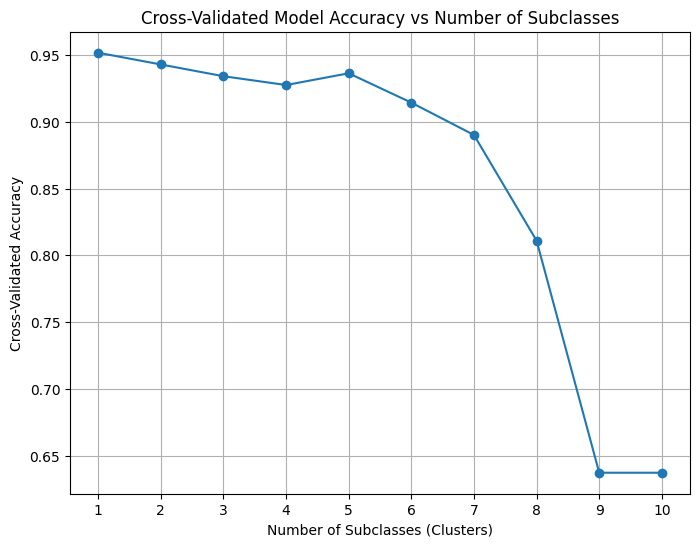

In [55]:
from sklearn.model_selection import cross_val_score



# Assuming 'standardized_data' and 'labels_data' are defined
X_train, X_test, y_train, y_test = train_test_split(standardized_data, labels_data, test_size=0.2, random_state=12345)

max_num_clusters = 10
accuracy_arr = []

for num_cluster in range(1, max_num_clusters+1):
    model = SupervisedGMM(num_clusters=num_cluster)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')  # 5-fold cross-validation
    mean_accuracy = np.mean(scores)
    accuracy_arr.append(mean_accuracy)
    print(f"Number of Clusters: {num_cluster}, Cross-Validated Accuracy: {mean_accuracy}")

# Plotting the accuracies
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, max_num_clusters+1), accuracy_arr, marker='o')
plt.title('Cross-Validated Model Accuracy vs Number of Subclasses')
plt.xlabel('Number of Subclasses (Clusters)')
plt.ylabel('Cross-Validated Accuracy')
plt.xticks(np.arange(1, max_num_clusters+1))
plt.grid(True)
plt.show()

c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
2


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
2


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
2


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
2


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
2
Number of Clusters: 1, Cross-Validated Accuracy: 0.9516483516483516


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
25


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
18


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
40


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
12


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
50
Number of Clusters: 2, Cross-Validated Accuracy: 0.9428571428571428
[0.62637363 0.37362637]


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


23


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
19


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
14


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
14


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
10
Number of Clusters: 3, Cross-Validated Accuracy: 0.9340659340659341
[0.62637363 0.37362637]


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


22


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
13


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
18


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
11


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
23
Number of Clusters: 4, Cross-Validated Accuracy: 0.9274725274725275
[0.62637363 0.37362637]


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


14


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
11


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
10


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
15


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
30
Number of Clusters: 5, Cross-Validated Accuracy: 0.9362637362637363
[0.62637363 0.37362637]


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


6


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
20


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
7


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
8


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
7
Number of Clusters: 6, Cross-Validated Accuracy: 0.9142857142857143
[0.62637363 0.37362637]


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


6


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
7


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
8


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
7


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
6
Number of Clusters: 7, Cross-Validated Accuracy: 0.8901098901098902
[0.62637363 0.37362637]


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


9


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
9


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
5


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
14


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
6
Number of Clusters: 8, Cross-Validated Accuracy: 0.810989010989011
[0.62637363 0.37362637]


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


6


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
6


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
5


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
5


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
6
Number of Clusters: 9, Cross-Validated Accuracy: 0.6373626373626373


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
5


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
5


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
4


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
5


c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\lemin\miniconda3\envs\ai1\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


[0.62637363 0.37362637]
4
Number of Clusters: 10, Cross-Validated Accuracy: 0.6373626373626373


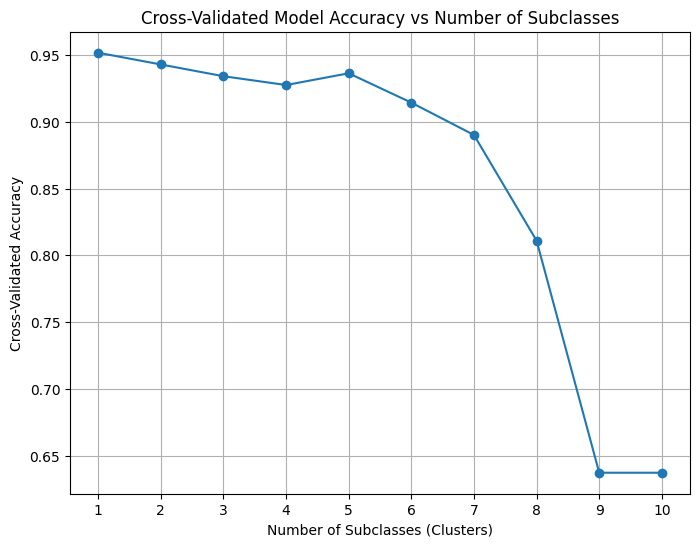

In [66]:
from sklearn.model_selection import cross_val_score

raw_iyer_data = parse_data_from_file_txt('iyer.txt')

iyer_data = raw_iyer_data[:, 3:]
iyer_labels = raw_iyer_data[:, 1] # labels
standardized_iyer_data = (iyer_data - iyer_data.mean(axis=0)) / iyer_data.std(axis=0)
labels_data = iyer_labels

# raw_breast_cancer_data_df = parse_data_from_file_csv('breast_cancer_data.csv')

# bc_data = raw_breast_cancer_data_df.iloc[:, 2:-2].apply(pd.to_numeric, errors='coerce')
# bc_labels = raw_breast_cancer_data_df.iloc[:, 1] # labels
# standardized_data = (bc_data - bc_data.mean(axis=0)) / bc_data.std(axis=0)
# standardized_data = standardized_data.to_numpy()
# vectorized_func = np.vectorize(lambda x: 1 if x == 'M' else 0)
# labels_data = vectorized_func(bc_labels)

# Assuming 'standardized_data' and 'labels_data' are defined
X_train, X_test, y_train, y_test = train_test_split(standardized_data, labels_data, test_size=0.2, random_state=12345)
max_num_clusters = 10
accuracy_arr = []

for num_cluster in range(1, max_num_clusters+1):
    model = SupervisedGMM(num_clusters=num_cluster)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')  # 5-fold cross-validation
    mean_accuracy = np.mean(scores)
    accuracy_arr.append(mean_accuracy)
    print(f"Number of Clusters: {num_cluster}, Cross-Validated Accuracy: {mean_accuracy}")

# Plotting the accuracies
plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, max_num_clusters+1), accuracy_arr, marker='o')
plt.title('Cross-Validated Model Accuracy vs Number of Subclasses')
plt.xlabel('Number of Subclasses (Clusters)')
plt.ylabel('Cross-Validated Accuracy')
plt.xticks(np.arange(1, max_num_clusters+1))
plt.grid(True)
plt.show()